Some libraries we'll be using:

In [8]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
import re
import sympy
from numpy.linalg import inv

## Theory

Some constants:

In [9]:
phi = 0.602 # fibre volume fraction
Ef = 230e9 # fibre tensile modulus (GPa)
Em = 2.4e9 # matrix tensile modulus (GPa)
Gf = 14e9 # fibre shear modulus (GPa)
Gm = 1.25e9 # matrix shear modulus (GPa)
sigma_f = 4900e6 # fibre UTS (MPa)
sigma_m = 60e6 # matrix UTS (MPa)
nu_m = 0.34 # matrix poisson ratio (_)
nu_f = 0.35 # fibre poisson ratio  (_)
angles = np.radians([0, 15, 30, 45, 90])
X1_T = 2282.0e6
X2_T = 53.55e6
X1_C = 1600.0e6
X2_C = 200.0e6
S6 = 99.0e6
Eps1_T = 0.02
Eps2_T = 0.0066
Gam6 = 0.0275
# Eps1_T = 0.0202
# Eps2_T = 0.004
# Gam6 = 0.13

Rule of mixtures to get simple properties:

Halpin-Tsai calculation:

In [10]:
def halpin_tsai_calc(p_m, p_f, phi, xi):
    """
    Calculates Halpin-Tsai propetry from matrix and fibre properties
    Parameters:
    ---------------------------------
    p_m, p_f: float
        Matrix and fibre properties
    phi: float
        Fibre volume fraction of composite
    xi: float
        xi in Halpin-Tsai eqn

    Returns:
    ----------------------------------
    p: float
        Halpin-Tsai property value
    """
    #chi = (p_f - p_m) / (p_f + xi * p_m)
    chi = ((p_f / p_m) - 1) / ((p_f/p_m) + xi)
    print("chi:", chi)
    p = (p_m * (1 + xi * chi * phi)) / (1 - chi * phi)
    return p

In [11]:
E1_th = phi * Ef + (1-phi) * Em
E2_th = (Ef * Em) / ((1-phi) * Ef + phi * Em)
nu12_th = phi * nu_f + (1-phi) * nu_m
G12_th = halpin_tsai_calc(Gm, Gf, phi, 1 + 40*phi**10)
E2_th_ht = halpin_tsai_calc(Em, Ef, phi, 2 + 40*phi**10)
nu21_th = E2_th / E1_th * nu12_th
nu21_th_ht = E2_th_ht / E1_th * nu12_th

chi: 0.8192738922472672
chi: 0.9668644290067554


In [12]:
E1_th/1e9

139.4152

In [13]:
E2_th/1e9

5.936454130137399

In [14]:
E2_th_ht/1e9

13.262789348524393

In [15]:
nu12_th

0.34602

In [16]:
nu21_th

0.014733916087414735

In [17]:
nu21_th_ht

0.03291743203306677

In [18]:
2 + 40*phi**10

2.2500488744019584

## Importing data

Locations of the data

In [19]:
XP_path = '../data/XP'
QI_path = '../data/QI'
UD_path = '../data/UD'

DATADIRS = [XP_path, QI_path, UD_path]

col_names = ['Time (s)', 'Sample elongation (mm)', 'Load (N)']
exp_names = ['XP', 'QI', 'UD']

In [20]:
def import_data(datadirs, col_names, exp_names):
    """
    Imports data from experiments

    Parameters:
    ---------------------------------
    datafiles: list
        List of data locations
    col_names: list
        List of columns in the datafiles

    Returns:
    ----------------------------------
    data: pandas dataframe
        Dataframe containing parsed data
    """
    data_experiments = []
    for datadir in datadirs:
        data = []
        # import data in each module
        for root, subdirs, filenames in os.walk(datadir):
            subdirs.sort()
            filenames.sort()
            for filename in filenames:
                if re.match('.*(csv|txt|xlsx)\Z', filename):
                         print("Importing", root + '/' + filename)
                         file_path = os.path.join(root, filename)
                         data.append(pd.read_csv(file_path, header=None, sep=None, 
                                    names=col_names, na_values=['no info', '.', 'NaN'], skiprows=8))
                        
        # concatenate the data into one result
        concat_keys = ['Sample ' + str(i) for i in range(len(data))]
        data_experiments.append(pd.concat(data, keys = concat_keys, names=['Sample'])) 
        
    alldata = pd.concat(data_experiments, keys=exp_names, names=['Experiment'])


    return alldata

In [21]:
data = import_data(DATADIRS, col_names,exp_names)

Importing ../data/XP/Specimen_RawData_1.csv
Importing ../data/XP/Specimen_RawData_2.csv
Importing ../data/XP/Specimen_RawData_3.csv
Importing ../data/XP/Specimen_RawData_4.csv
Importing ../data/QI/Specimen_RawData_1.csv
Importing ../data/QI/Specimen_RawData_2.csv
Importing ../data/QI/Specimen_RawData_3.csv
Importing ../data/QI/Specimen_RawData_4.csv
Importing ../data/QI/Specimen_RawData_5.csv


/home/m/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.


Importing ../data/UD/Specimen_RawData_1.csv
Importing ../data/UD/Specimen_RawData_2.csv
Importing ../data/UD/Specimen_RawData_3.csv
Importing ../data/UD/Specimen_RawData_4.csv
Importing ../data/UD/Specimen_RawData_5.csv


Import theory

In [22]:
# theory_path = '../theory'
# theory_col_names = ['Stress (Pa)', 'Strain (_)']
# theory_QI_path = '../theory/QI_tsai_wu.csv'
# theory_XP_path = '../theory/XP_tsai_wu.csv'
# theory_QI = pd.read_csv(theory_QI_path, names=theory_col_names, usecols=[1, 4], skiprows=1)
# theory_XP = pd.read_csv(theory_XP_path, names=theory_col_names, usecols=[1, 4], skiprows=1)
# theory_QI['Stress (Pa)'] = theory_QI['Stress (Pa)'] * 1e6
# theory_XP['Stress (Pa)'] = theory_XP['Stress (Pa)'] * 1e6

In [23]:
# sns.relplot(x='Strain (_)', y='Stress (Pa)', 
#             data=theory_QI, kind='line')

In [24]:
data.head()

Time (s)  Sample elongation (mm)  Load (N)
Experiment Sample                                                
XP         Sample 0 0       0.6                 0.05363   1.66773
                    1       0.7                 0.06213   1.99441
                    2       0.8                 0.07119   2.33128
                    3       0.9                 0.08019   2.67090
                    4       1.0                 0.08925   2.98300

And delete unnecessary columns

In [25]:
# del data['Poisson ratio (%)']
# del data['Real stress (GPa)']
# del data['Real area (mm^2)']

Make a raw table and then delete the time column

In [26]:
raw_data =  data.loc[exp_names[0], 'Sample 0'].head()
del raw_data['Time (s)']

In [27]:
print(raw_data.to_latex(escape = True))

\begin{tabular}{lrr}
\toprule
{} &  Sample elongation (mm) &  Load (N) \\
\midrule
0 &                 0.05363 &   1.66773 \\
1 &                 0.06213 &   1.99441 \\
2 &                 0.07119 &   2.33128 \\
3 &                 0.08019 &   2.67090 \\
4 &                 0.08925 &   2.98300 \\
\bottomrule
\end{tabular}



And plot a few cases

In [28]:
quickplot_load = lambda data, separator: sns.relplot(x='Sample elongation (mm)', y='Load (N)', 
                                                data=data, kind='line', hue=separator)
def plot_sample_data(_data, _x, _y):
    data_reset = _data.reset_index(level='Sample')
    return sns.relplot(x=_x, y=_y, data=data_reset, kind='line', hue='Sample')

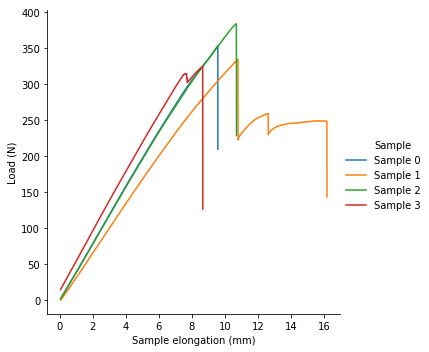

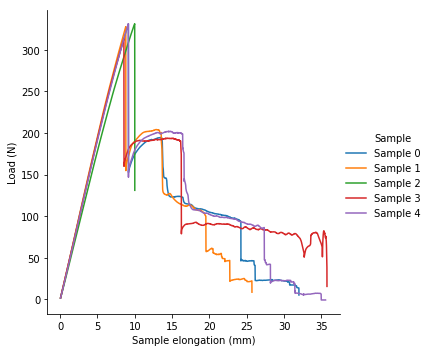

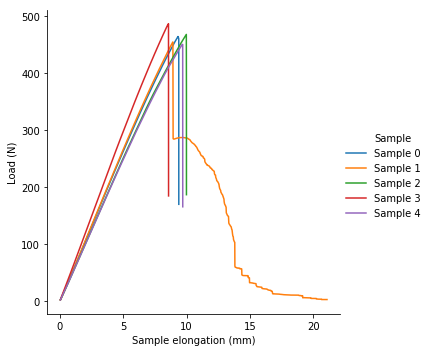

In [29]:
data_reset = data.reset_index(level='Sample')
fig = quickplot_load(data_reset.loc['XP'], 'Sample')
fig.savefig('../figs/XP_raw.pdf', format = 'pdf')
fig = quickplot_load(data_reset.loc['QI'], 'Sample')
fig.savefig('../figs/QI_raw.pdf', format = 'pdf')
data_reset = data.reset_index(level='Sample')
fig = quickplot_load(data_reset.loc['UD'], 'Sample')
fig.savefig('../figs/UD_raw.pdf', format = 'pdf')


That works, adding the rest of the geometry

In [30]:
def add_geometry(data, TESTS, WIDTHS, THICKNESSES, FVFS):
    data = data.assign(Width=25e-3, Thickness=2e-3, FVF=0.602)
    data = data.rename(columns = {'Width':'Width (m)', 'Thickness': 'Thickness (m)', 'FVF': 'FVF (_)'})
    for _test, _width, _thickness, _fvf in zip(TESTS, WIDTHS, THICKNESSES, FVFS):
        for i in range(len(_width)):
            sample_name = 'Sample ' + str(i)
            data.loc[(_test, sample_name), 'Width (m)'] = _width[i]
            data.loc[(_test, sample_name), 'Thickness (m)'] = _thickness[i]
            data.loc[(_test, sample_name), 'FVF (_)'] = _fvf
    return data
    
QI_width = np.array([15.27, 15.28, 15.26, 15.21, 15.27]) * 1e-3
QI_thickness = np.array([1.83, 1.83, 1.73, 1.79, 1.82]) * 1e-3

XP_width = np.array([15.21, 15.30, 15.24, 15.19]) * 1e-3
XP_thickness = np.array([1.74, 1.59, 1.73, 1.76]) * 1e-3

UD_width = np.array([15.08, 15.10, 15.28, 15.15, 15.12]) * 1e-3
UD_thickness = np.array([1.68, 1.71, 1.72, 1.78, 1.61]) * 1e-3

QI_FVF = 0.602
XP_FVF = 0.602
UD_FVF = 0.602

SAMPLE_LENGTH = 0.08

WIDTHS = [XP_width, QI_width, UD_width]
THICKNESSES = [XP_thickness, QI_thickness, UD_thickness]
FVFS = [XP_FVF, QI_FVF, UD_FVF]
data = add_geometry(data, exp_names, WIDTHS, THICKNESSES, FVFS)


# Stress calculations
The standard asks for engineering stress, so we need the sample areas.

In [31]:
areas = data['Width (m)'] * data['Thickness (m)']

In [32]:
stresses = (3 * data['Load (N)'] * SAMPLE_LENGTH / 
            (2 * data['Width (m)'] * data['Thickness (m)'] * data['Thickness (m)']))

In [33]:
strains = (6 * data['Sample elongation (mm)'] * 1e-3 * data['Thickness (m)']
          / (SAMPLE_LENGTH * SAMPLE_LENGTH))

In [34]:
data = data.assign(Area = areas, Stress = stresses, Strain = strains)
data = data.rename(columns = {'Area':'Area (m^2)', 'Stress': 'Stress (Pa)', 'Strain': 'Strain (_)'})

In [35]:
# theory_QI = pd.concat([theory_QI], keys=['Theory'], names=['Sample'])
# theory_XP = pd.concat([theory_XP], keys=['Theory'], names=['Sample'])
# with_theory_QI = pd.concat([data.loc['QI'], theory_QI], join='outer', verify_integrity=True)
# with_theory_XP = pd.concat([data.loc['XP'], theory_XP], join='outer', verify_integrity=True)

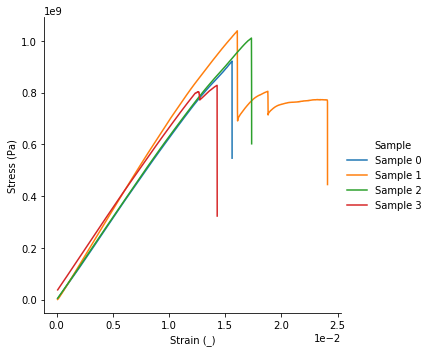

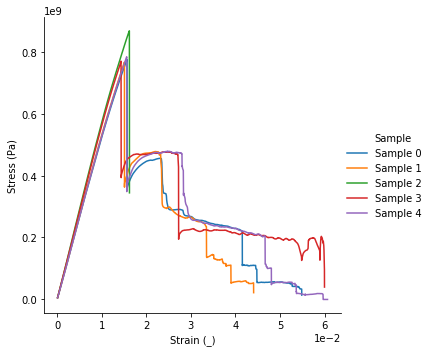

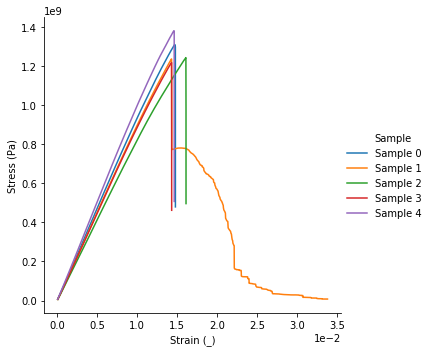

In [36]:
for exp in exp_names:
    fig = plot_sample_data(data.loc[exp], \
                           'Strain (_)', 'Stress (Pa)')
    for ax in fig.axes.flatten():
        ax.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
    fig.savefig('../figs/' + exp + '_ss.pdf', format = 'pdf')

In [37]:
# fig = plot_sample_data(data.loc[exp_names[0]][data.loc[exp_names[0], 'Sample elongation (mm)'] > -1], \
#                     'Strain (_)', 'Transverse strain (_)')
# for ax in fig.axes.flatten():
#     ax.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
# fig.savefig('../figs/' + exp_names[0] + '_sstrain.pdf', format = 'pdf')

In [38]:
# fig = plot_sample_data(data.loc[exp_names[1]][data.loc[exp_names[1], 'Sample elongation (mm)'] > -1], \
#                     'Strain (_)', 'Transverse strain (_)')
# for ax in fig.axes.flatten():
#     ax.ticklabel_format(style='sci', scilimits=(0,0), axis='both')
# fig.savefig('../figs/' + exp_names[1] + '_sstrain.pdf', format = 'pdf')

# Analysis

In [39]:
def calc_moduli(data, strain_col, strain_low, strain_high, samples, name):
    """
    calculates modulus from data
    """
    # access the index property to get the no. of samples
    moduli = []
    sample_names = []

    for i in range(samples[0], samples[1]):
        # get index of lower stress value
        sample_name = "Sample " + str(i)
        sample_data = data.loc[sample_name]
        idx_low = (sample_data[strain_col] - strain_low).abs().idxmin()
        idx_high = (sample_data[strain_col] - strain_high).abs().idxmin()
        e_h = sample_data['Stress (Pa)'].iloc[idx_high]
        e_low = sample_data['Stress (Pa)'].iloc[idx_low]
        print('high', e_h, 'low', e_low)
        delta_stress = sample_data['Stress (Pa)'].iloc[idx_high] - sample_data['Stress (Pa)'].iloc[idx_low]
        delta_strain = strain_high - strain_low
        moduli.append(delta_stress / delta_strain / 1e9)
        sample_names.append(sample_name),
    return pd.DataFrame(moduli, index = sample_names, columns = [name])
        

In [40]:
def calc_poisson(data, strain_long, strain_trans, strain_low, strain_high, samples, name):
    """
    calculates modulus from data
    """
    # access the index property to get the no. of samples
    moduli = []
    sample_names = []
    for i in range(samples[0], samples[1]):
        # get index of lower stress value
        sample_name = "Sample " + str(i)
        sample_data = data.loc[sample_name]
        idx_low = (sample_data[strain_long] - strain_low).abs().idxmin()
        idx_high = (sample_data[strain_long] - strain_high).abs().idxmin()
        delta_e1 = sample_data[strain_long].iloc[idx_high] - sample_data[strain_long].iloc[idx_low]
        delta_e2 = sample_data[strain_trans].iloc[idx_high] - sample_data[strain_trans].iloc[idx_low]
        moduli.append(-delta_e2 / delta_e1)
        sample_names.append(sample_name)
    return pd.DataFrame(moduli, index = sample_names, columns = [name])

In [41]:
def get_stats(data):
    mean = data.mean()
    std = data.std()
    cov = std / mean * 100
    return mean, std, cov

In [42]:
def get_vals(data, strain_low, strain_high, samples, poisson=True):
    X1 = pd.DataFrame(data['Stress (Pa)'].abs().max(level='Sample') / 1e6)
    X1.columns = ['$X_{1}^{T}$ (MPa)']
    E1 = calc_moduli(data, 'Strain (_)', strain_low, strain_high, samples, '$E_{1}$ (GPa)')
    #nuxy = calc_poisson(data, 'Strain (_)', 'Transverse strain (_)',  strain_low, strain_high, samples, '$\nu_{xy}$ (\_)')
    return pd.concat([X1, E1], axis = 1, sort=False) 

In [43]:
def get_vals_gauge(data, strain_low, strain_high):
    E1_gauge = calc_moduli(data, 'Strain gauge 0 (_)', strain_low, strain_high, 5, '$E_{x}$')
    nuxy_gauge = calc_poisson(data, 'Strain gauge 0 (_)', 'Transverse strain gauge (_)',  strain_low, strain_high, 5, '$\nu_{xy}$')
    etaxy_gauge =  calc_poisson(data, 'Strain gauge 0 (_)', 'Shear strain gauge (_)',  strain_low, strain_high, 5, '$\eta_{xy}$')
    etaxy_gauge = etaxy_gauge.abs()
    return pd.concat([E1_gauge, nuxy_gauge, etaxy_gauge], axis = 1, sort=False) 

## XP

In [44]:
vals_XP = get_vals(data.loc['XP'], 0.0005, 0.0025, [0, 4])
vals_XP.describe()

high 154685193.3936906 low 28868088.79674515
high 168093530.6759862 low 27131869.163155153
high 158409969.2105963 low 30867462.443267964
high 193837213.1377211 low 64257099.46735292


$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)
count           4.000000       4.000000
mean          949.371492      65.487673
std            95.158732       3.416443
min           827.803666      62.908552
25%           897.881417      63.555578
50%           965.742982      64.280655
75%          1017.233057      66.212750
max          1038.196336      70.480831

In [45]:
vals_XP

$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)
Sample                                    
Sample 0         921.240667      62.908552
Sample 1        1038.196336      70.480831
Sample 2        1010.245297      63.771253
Sample 3         827.803666      64.790057

## QI

In [46]:
vals_QI = get_vals(data.loc['QI'], 0.0005, 0.0025, [0, 5])
vals_QI.describe()

high 130547138.57601307 low 25122661.45391786
high 132393359.13847774 low 25484831.387160182
high 142337231.75429562 low 26600385.43819762
high 139149549.94485304 low 26590684.137625188
high 130282543.72627091 low 24471077.185945816


$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)
count           5.000000       5.000000
mean          794.696399      54.644018
std            42.781697       2.304360
min           768.447161      52.712239
25%           771.670617      52.905733
50%           777.080097      53.454264
75%           785.985648      56.279433
max           870.298474      57.868423

In [47]:
vals_QI

$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)
Sample                                    
Sample 0         777.080097      52.712239
Sample 1         768.447161      53.454264
Sample 2         870.298474      57.868423
Sample 3         771.670617      56.279433
Sample 4         785.985648      52.905733

## UD

In [48]:
vals_UD = get_vals(data.loc['UD'], 0.0005, 0.0025, [0, 5])
vals_UD.describe()

high 232150328.6327794 low 44908983.15559646
high 221329870.89931563 low 40138660.426675685
high 202266197.7324661 low 38644111.08027829
high 220872852.08763272 low 42960422.28891492
high 248023818.4030476 low 47224013.37886851


$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)
count           5.000000       5.000000
mean         1277.930577      91.076688
std            67.196707       6.781855
min          1218.117524      81.811043
25%          1236.960287      88.956215
50%          1243.572159      90.595605
75%          1310.193706      93.620673
max          1380.809211     100.399903

In [49]:
vals_UD

$X_{1}^{T}$ (MPa)  $E_{1}$ (GPa)
Sample                                    
Sample 0        1310.193706      93.620673
Sample 1        1236.960287      90.595605
Sample 2        1243.572159      81.811043
Sample 3        1218.117524      88.956215
Sample 4        1380.809211     100.399903

## Summaries

In [50]:
def make_summary(*args):
    args = list(args)
    summary = args.pop(0)
    
    for arg in args:
        summary = summary.join(arg)
   
    mean = summary.mean()
    std_dev = summary.std()
    DOV = summary.std() / summary.mean() * 100

    summary.loc['Mean'] = mean
    summary.loc['Standard deviation'] = std_dev
    summary.loc['DOV'] = DOV

    latex_tab = summary.to_latex(float_format='%.2f', escape = False)
    
    print(latex_tab)
    return summary, latex_tab

In [51]:
XP_summary, _ = make_summary(vals_XP)

\begin{tabular}{lrr}
\toprule
{} &  $X_{1}^{T}$ (MPa) &  $E_{1}$ (GPa) \\
Sample             &                    &                \\
\midrule
Sample 0           &             921.24 &          62.91 \\
Sample 1           &            1038.20 &          70.48 \\
Sample 2           &            1010.25 &          63.77 \\
Sample 3           &             827.80 &          64.79 \\
Mean               &             949.37 &          65.49 \\
Standard deviation &              95.16 &           3.42 \\
DOV                &              10.02 &           5.22 \\
\bottomrule
\end{tabular}



In [52]:
QI_summary, _ = make_summary(vals_QI)

\begin{tabular}{lrr}
\toprule
{} &  $X_{1}^{T}$ (MPa) &  $E_{1}$ (GPa) \\
Sample             &                    &                \\
\midrule
Sample 0           &             777.08 &          52.71 \\
Sample 1           &             768.45 &          53.45 \\
Sample 2           &             870.30 &          57.87 \\
Sample 3           &             771.67 &          56.28 \\
Sample 4           &             785.99 &          52.91 \\
Mean               &             794.70 &          54.64 \\
Standard deviation &              42.78 &           2.30 \\
DOV                &               5.38 &           4.22 \\
\bottomrule
\end{tabular}



In [53]:
UD_summary, _ = make_summary(vals_UD)

\begin{tabular}{lrr}
\toprule
{} &  $X_{1}^{T}$ (MPa) &  $E_{1}$ (GPa) \\
Sample             &                    &                \\
\midrule
Sample 0           &            1310.19 &          93.62 \\
Sample 1           &            1236.96 &          90.60 \\
Sample 2           &            1243.57 &          81.81 \\
Sample 3           &            1218.12 &          88.96 \\
Sample 4           &            1380.81 &         100.40 \\
Mean               &            1277.93 &          91.08 \\
Standard deviation &              67.20 &           6.78 \\
DOV                &               5.26 &           7.45 \\
\bottomrule
\end{tabular}



# Scratchbook

Error analysis

In [54]:
error_mult = lambda val, errors: val * np.sqrt(np.sum(np.square(errors)))

Es

In [55]:
error_mult(65.49, [0.03] + 3*[0.025] + [0.01] + 3*[0.02] + [0.03])

4.619250696541593

In [56]:
error_mult(65.49, [0.03] + 3*[0.025] + [0.002] + 3*[0.08] + [0.03])

9.905890194621582

In [57]:
error_mult(65.49, [0.03] + 3*[0.025] + [0.01] + 3*[0.04] + [0.03])

6.064458867656701

Xs

In [58]:
error_mult(949.4, [0.03, 0.025, 0.01] + 3*[0.03])

62.437036741024144

In [59]:
error_mult(794.7, [0.03, 0.025, 0.002] + 3*[0.08])

114.41748274459636

In [60]:
error_mult(1278, [0.03, 0.025, 0.01] + 3*[0.04])

102.43949287262213

Differences

In [61]:
diff = lambda x, y: (y-x)/x

In [73]:
xs_E = np.array([65.49, 54.64, 91.08])
ys_E = np.array([79.2, 41.2, 110.6])

In [74]:
diff(xs_E, ys_E)*100

array([ 20.93449382, -24.59736457,  21.43170839])

In [75]:
xs_X = np.array(3*[1277.9])
ys_X = np.array([1441, 1441, 1170])

In [77]:
diff(xs_X, ys_X)*100

array([12.76312701, 12.76312701, -8.44354018])

In [66]:
diff(64.1, 27.8)

-0.5663026521060842

In [67]:
diff(2.02, 1.84)

-0.08910891089108908

In [68]:
def failure_stress(bending_moment, width, thickness):
    moment = bending_moment * 0.015
    stress = 6 * moment / (width * thickness * thickness)
    return stress

In [69]:
failure_stress(700, 0.015, 0.00175) / 1e6 

1371.4285714285713

Max stress

In [70]:
# XP, QI, UD
failure_moments = np.array([4.13999E+02 , 3.72308E+02, 7.00320E+02]) # 7 , 7, 1
widths = np.array([0.01522, 0.01526, 0.01514])
thicknesses = np.array([0.00171, 0.0018, 0.00170])
failure_stress(failure_moments, widths, thicknesses) / 1e6

array([ 837.21100478,  677.71224698, 1440.50682671])

In [71]:
# XP, QI, UD
failure_moments = np.array([4.06771E+02, 3.56525E+02,  7.00320E+02])
# 
failure_stress(failure_moments, widths, thicknesses) / 1e6

array([ 822.59415512,  648.98245231, 1440.50682671])

In [72]:
def pos_at_failure(force, modulus, width, thickness):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-72-6eb6bf144ead>, line 2)

In [ ]:
# with thermal
# max_stress
failure_moments = np.array([287, 258,   700])
failure_stress(failure_moments, widths, thicknesses) / 1e6


In [ ]:
#tw
failure_moments = np.array([278, 244,  700])
failure_stress(failure_moments, widths, thicknesses) / 1e6


In [ ]:
7.6/13.9 * 250

In [78]:
diff(6.78, 6.06)

-0.10619469026548682